In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

"Libraries to help with data processing"
from scipy import stats

"Libraries to help with jupyter notebook usage"
# Increases jupyter notebook display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.display import Image # Helps display images in notebook

In [3]:
"Import python util functions"
import sys
sys.path.append('..')  # Add the parent directory to the Python path

# Now you can import the util functions
from jupyternotebook_utils import *

## Data Import
Import files containing information regarding tracks from over 10,000 playlists in terms of audio featuers and various details such as global popularity and release date

In [4]:
audio_features_df = []
track_details_df = []

for i in range(10):
    audio_features_file_path = f'../../data/processed_data/audio_features/audio_features-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(audio_features_file_path)
    audio_features_df.append(df)
    
    track_details_file_path = f'../../data/processed_data/playlist_details/details-{i*1000}-{(i+1)*1000 - 1}.csv'
    df = pd.read_csv(track_details_file_path)
    track_details_df.append(df)

audio_features_df = pd.concat(audio_features_df, ignore_index=True)
track_details_df = pd.concat(track_details_df, ignore_index=True)

original_track_details_df = track_details_df.copy()
original_audio_features_df = audio_features_df.copy()

## Data Pre-processing
1. Perform min-max normalisation on audio features with custom ranges
2. Remove irrelevant columns
3. Various Normalization Techniques
4. Standard Normalization
5. Perform One-Hot-Encoding (OHE) for `track_popularity` and `release_date` in `track_details_df`

### Data Processing Utilities
Constants and Functions that will be used for data processing

In [5]:
before_graph_audio_features_df = audio_features_df.copy()
after_graph_audio_features_df = audio_features_df.copy()
original_graph_audio_features_df = audio_features_df.copy()

num_bins = 250

graph_height = 4
graph_width = 4

audio_features_list = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
                       'acousticness', 'instrumentalness', 'liveness', 'valence',
                       'tempo', 'duration_ms']

def plot_graph(plot_title, subplots_per_row, graph_features_list=audio_features_list, max_x=1, graph_df=after_graph_audio_features_df):
    num_features = len(graph_features_list)
    num_rows = (num_features + subplots_per_row - 1) // subplots_per_row
    total_subplots = num_rows * subplots_per_row
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(25, 6 * num_rows))
    axes = axes.flatten()
    
    for i, audio_feature in enumerate(graph_features_list):
            ax = axes[i]
            ax.hist(graph_df[audio_feature], bins=num_bins, range=(0, max_x), edgecolor='none')
            ax.set_title(f'{str(audio_feature).capitalize()}')
            ax.set_xlabel(f'{audio_feature.capitalize()}')
            ax.set_ylabel('Frequency')
            ax.set_xlim(0, max_x)
            
    # Hide extra subplots
    for i in range(num_features, total_subplots):
        axes[i].set_visible(False)
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Initial Raw Dataset

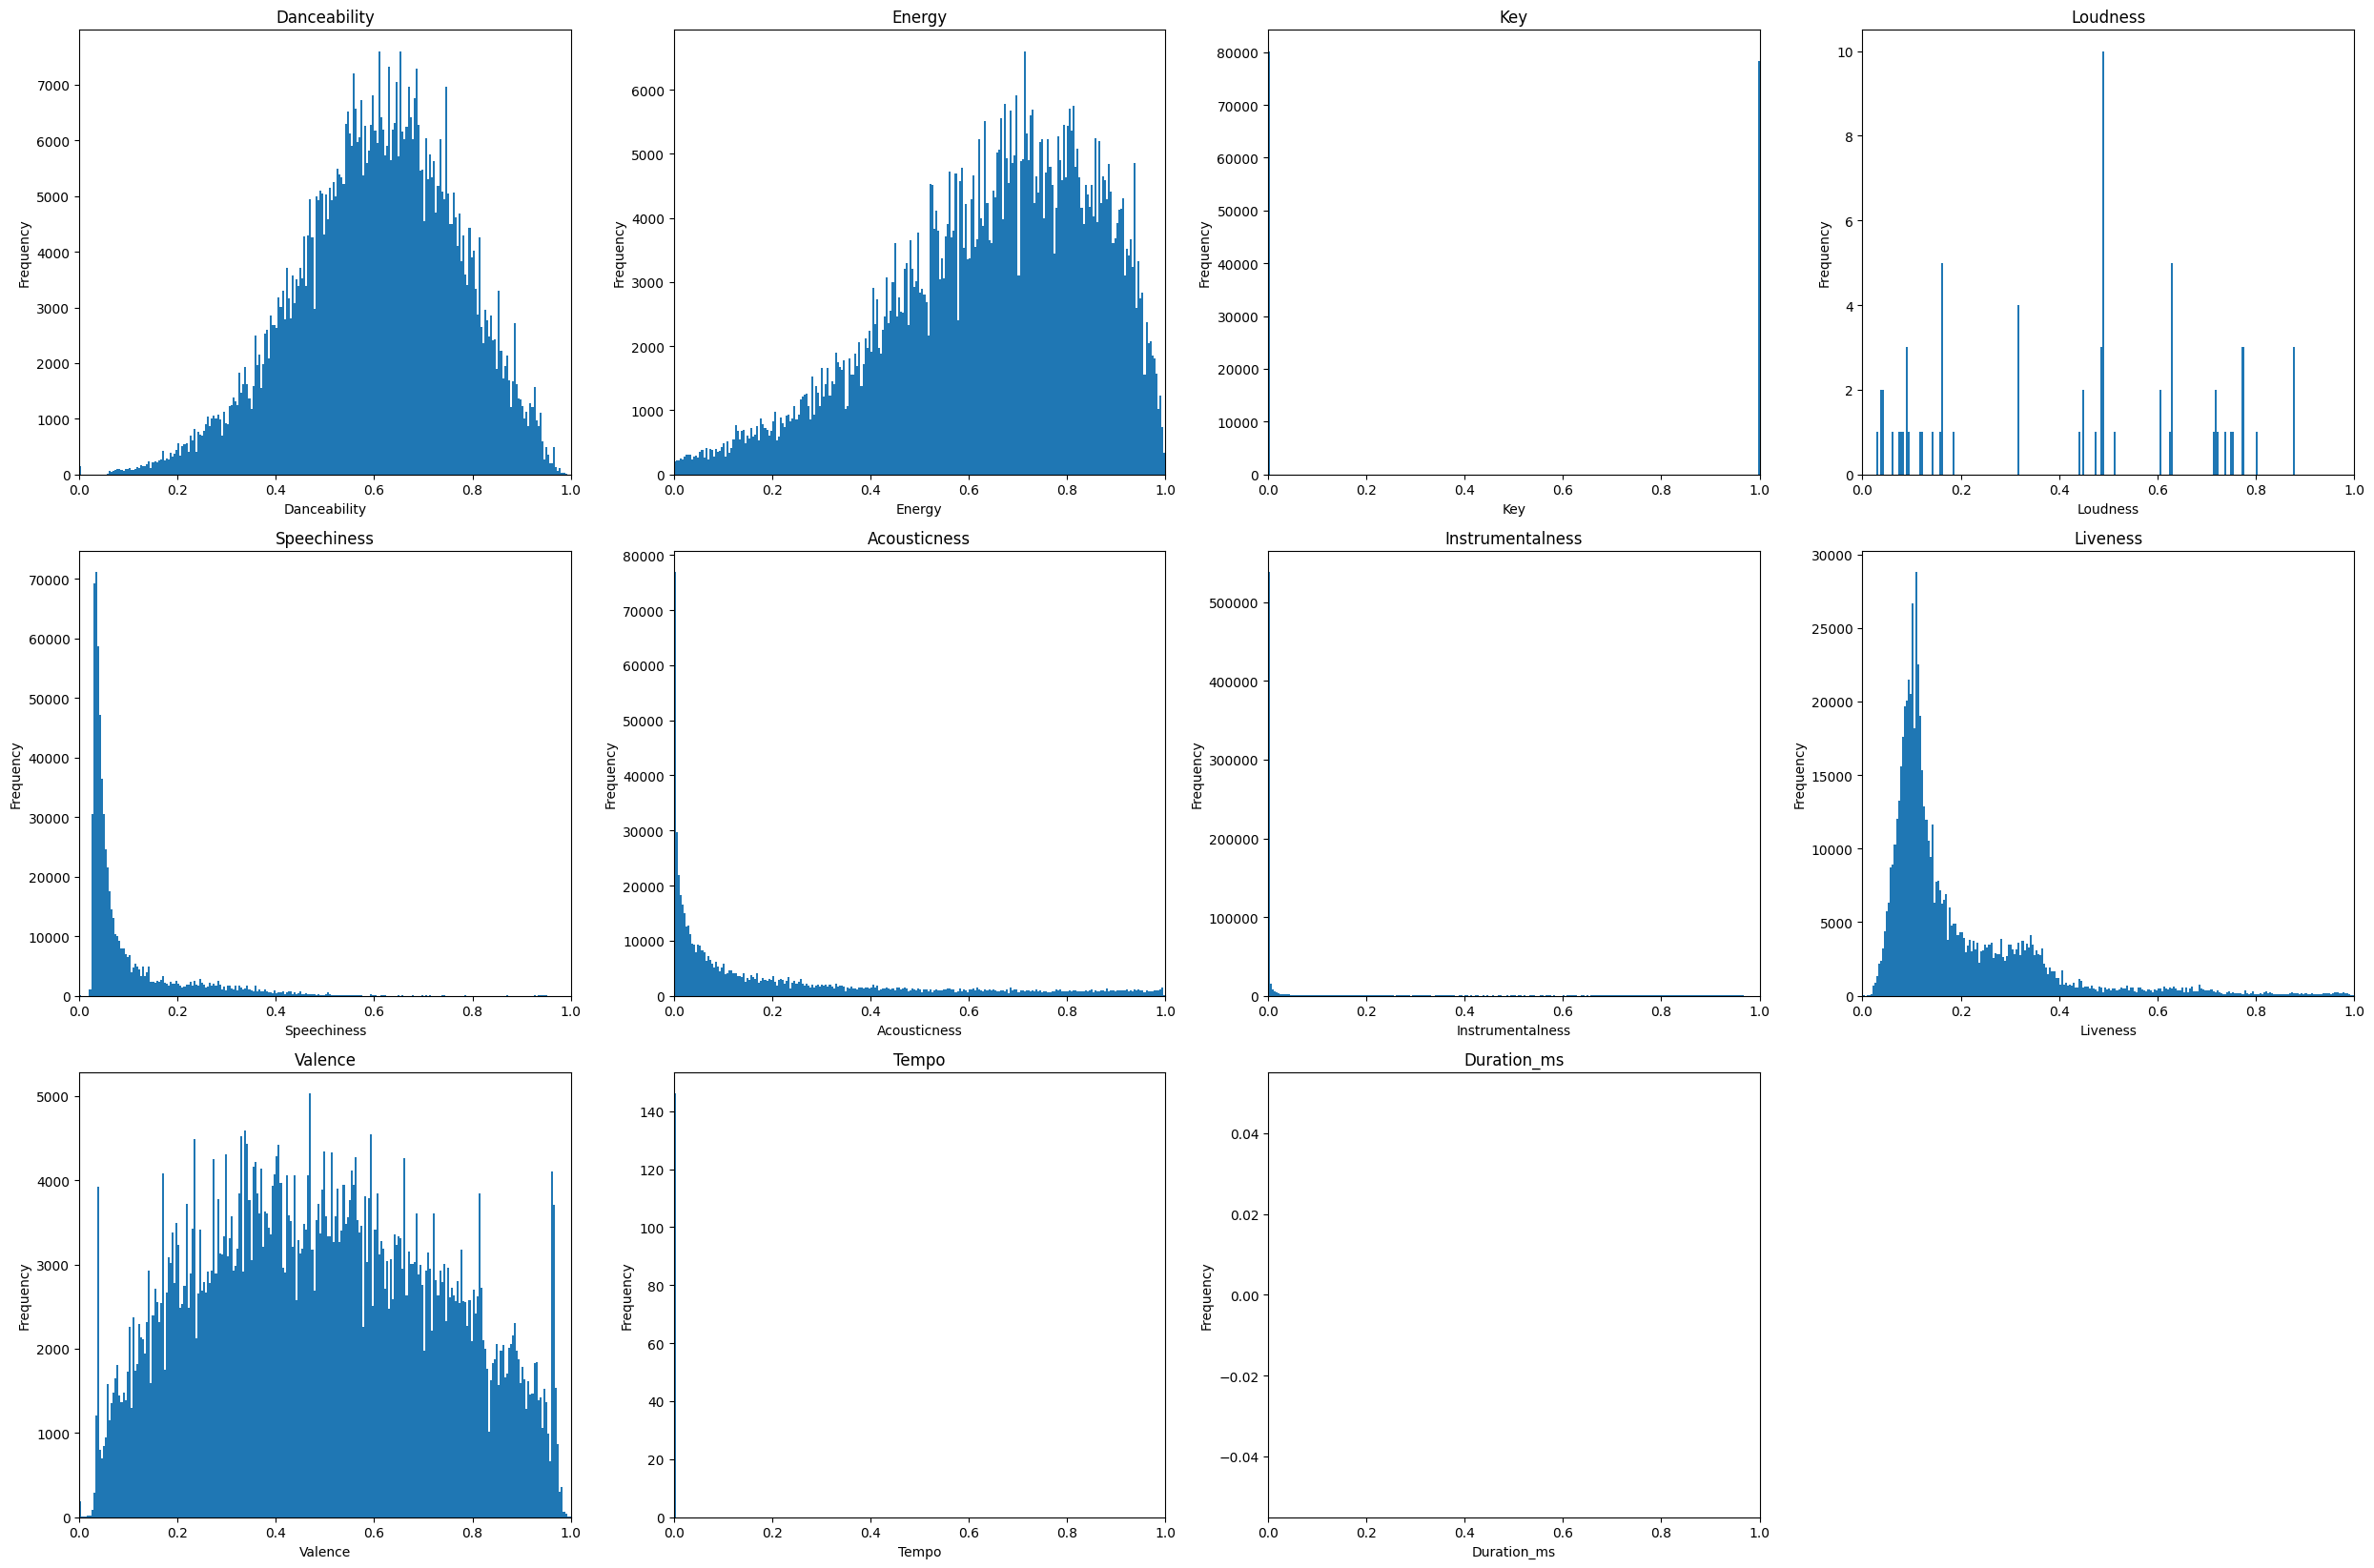

In [6]:
graph_title = 'Initial Frequency Histogram of Raw Dataset'

plot_graph(graph_title, subplots_per_row=4, max_x=1)

### 1. Min-max Normalization
To ensure equal weighting of audio features when building up the playlist vector, we can scale all audio features to a common scale, namely [0, 1]. After some research on the Spotify API documentation, there are 3 audio features with ranges outside of [0, 1], such as:

    - Loudness: [-60, 0]
    - Tempo: [0, 250]
    - Key: [-1, 11]

We can perform Min-Max normalization to set up the data for further processing.

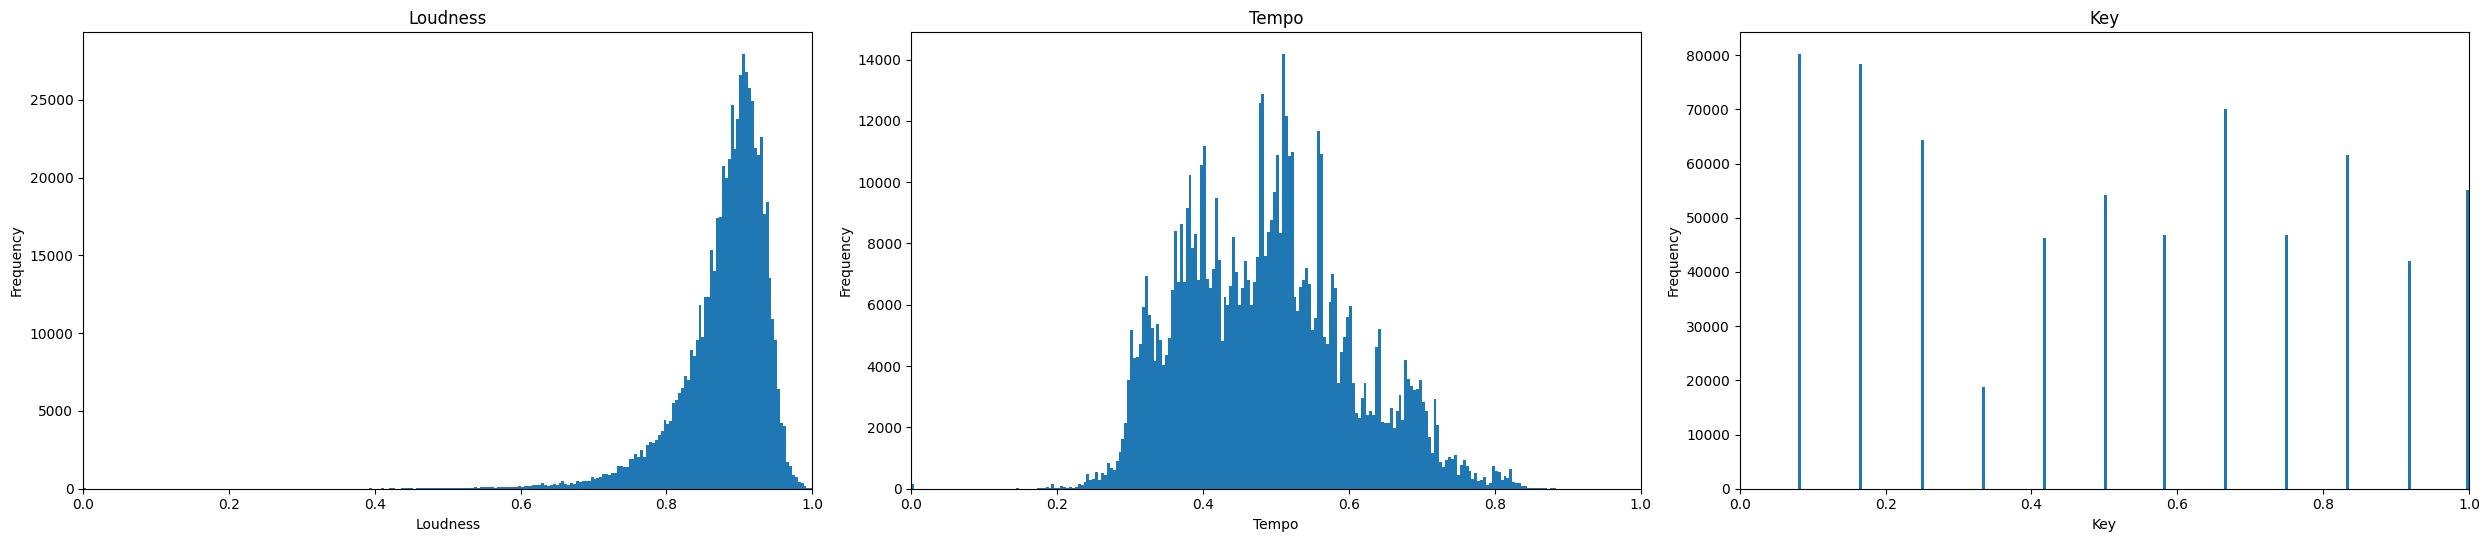

In [7]:
input_data_ranges = {
    'loudness': (-60, 0),
    'tempo': (0, 250),
    'key': (-1, 11)
}

# min-max normalization
for column, (input_min, input_max) in input_data_ranges.items():
    after_graph_audio_features_df[column] = (before_graph_audio_features_df[column] - input_min) / (input_max - input_min)

plot_graph(plot_title='After Min-max Normalization', subplots_per_row=3, max_x=1, graph_features_list=['loudness', 'tempo', 'key'])

before_graph_audio_features_df = after_graph_audio_features_df.copy()

### 2. Removing Irrelevant Columns

While analyzing the audio features for building our recommendation system, it became evident that certain columns don't contribute significantly to the process. Specifically, the `key` and `duration_ms` columns fall into this category. Allow me to explain:
- `key`: the musical key of a track, doesn't provide substantial insights relevant to our recommendation system's objectives. 
- `duration_ms`: the length of a track doesn't really hold the significance needed to recommend songs effectively.

In [8]:
audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness','acousticness', 'liveness', 'valence']

Another thing that can be observed is the incompleteness of data for a track's `instrumentalness`. Almost half of the data is 0, with the 75th percentile being less than 0.001 as well. Hence it will be removed from the analysis as well.

In [9]:
zero_rows_count =  (after_graph_audio_features_df['instrumentalness'] == 0).sum()
print(f"Rows with 0 for 'instrumentalness': {zero_rows_count}, ({round(zero_rows_count * 100 / len(after_graph_audio_features_df), 1)}%)")

after_graph_audio_features_df['instrumentalness'].describe()

Rows with 0 for 'instrumentalness': 288862, (43.5%)


count    664712.000000
mean          0.056641
std           0.187687
min           0.000000
25%           0.000000
50%           0.000004
75%           0.000827
max           0.999000
Name: instrumentalness, dtype: float64

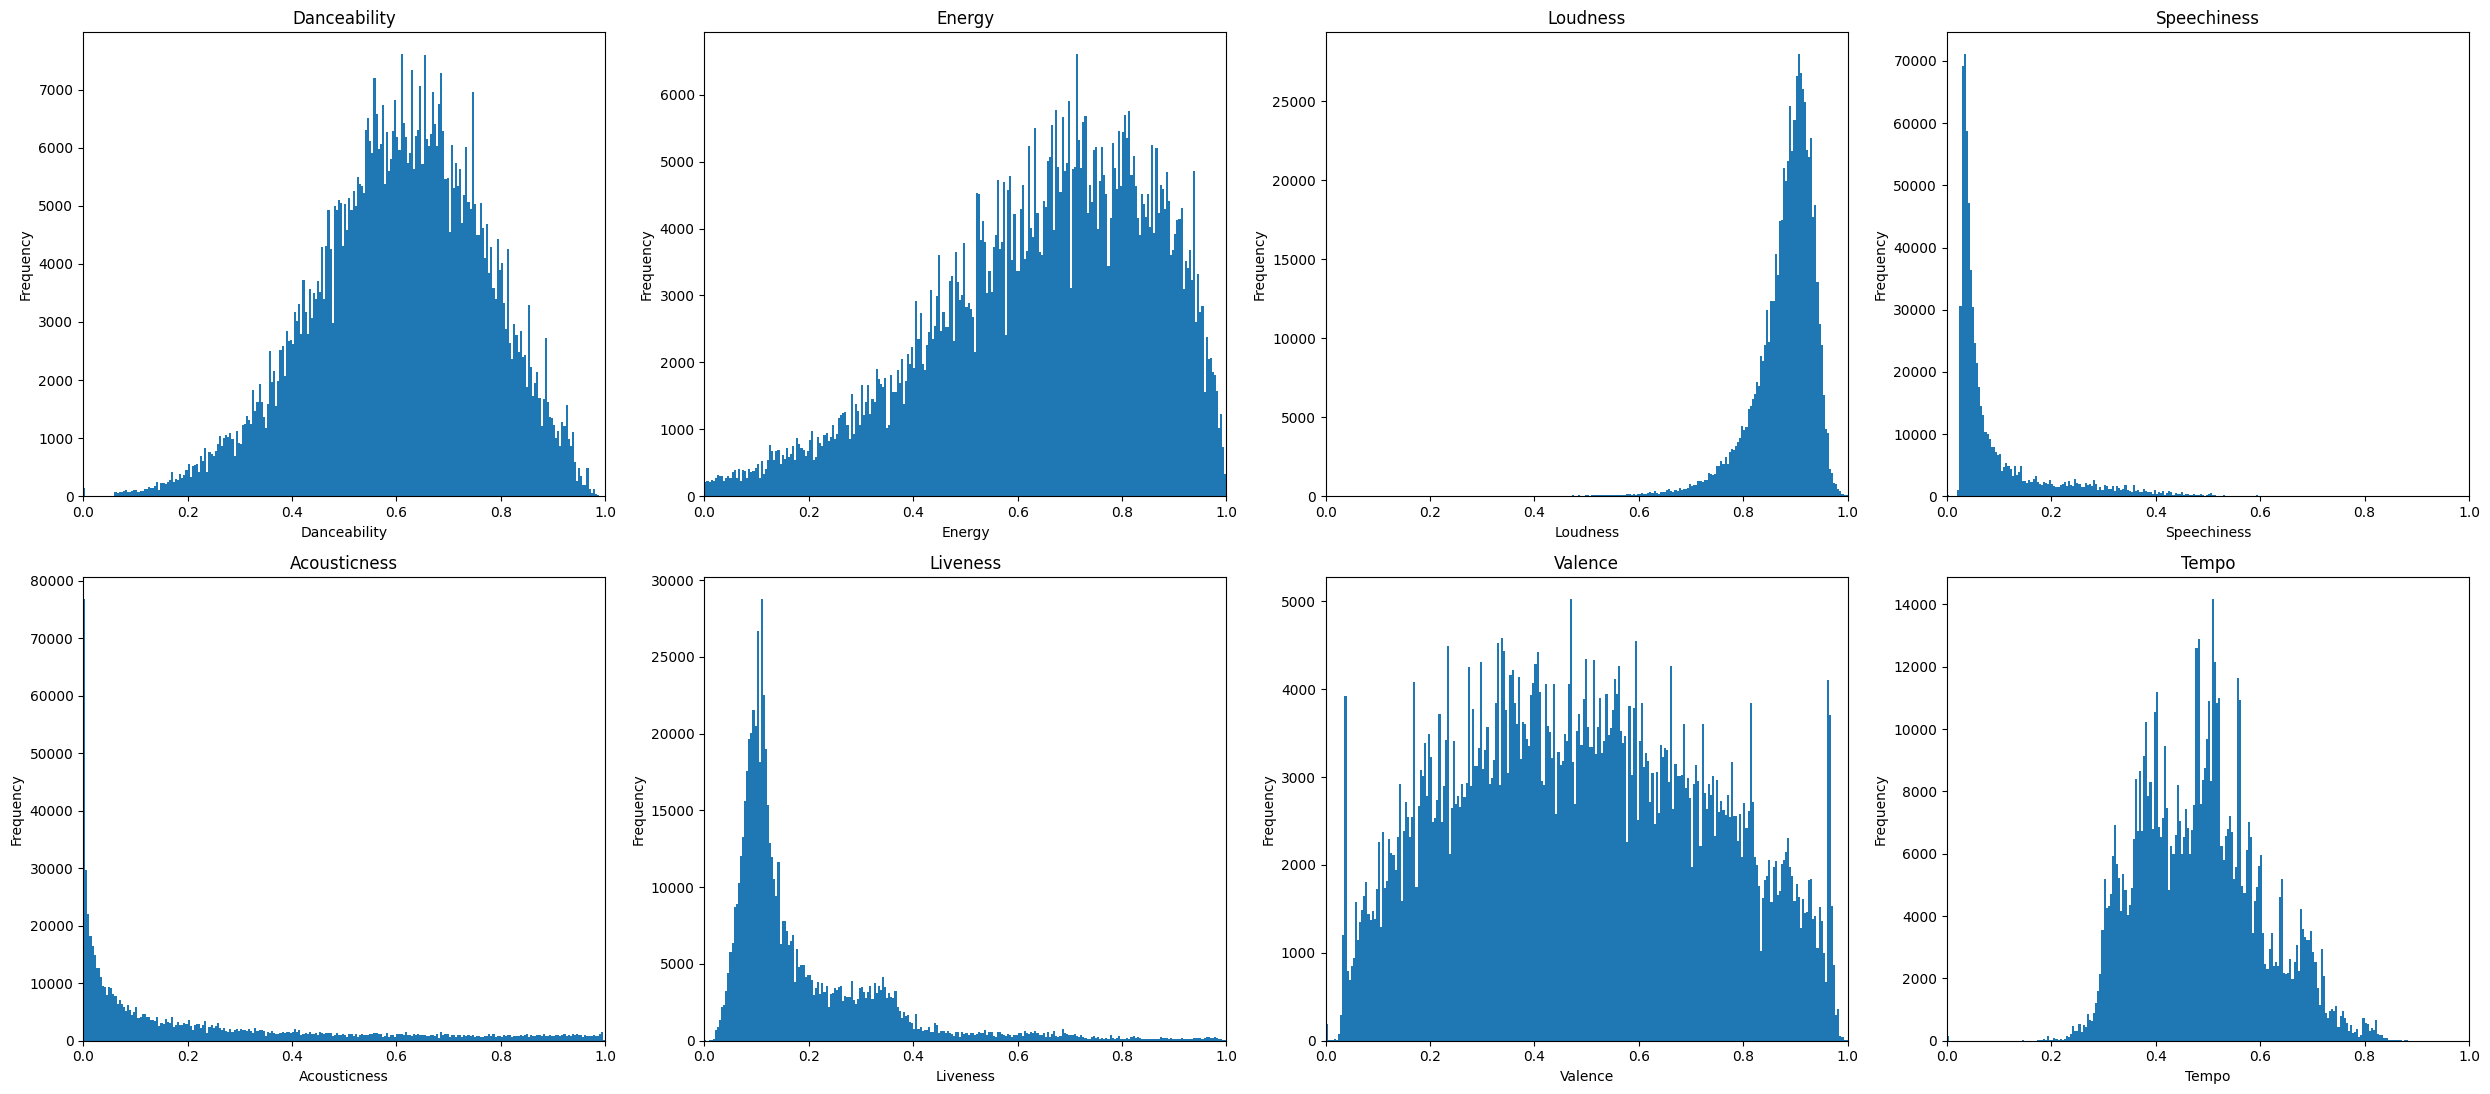

In [10]:
audio_features_list = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']

plot_title = 'Updated Frequency Histogram'
plot_graph(plot_title, subplots_per_row=4, graph_features_list=audio_features_list)

### 3. Fix Left/Right-skewed Data
For right-skewed data, we will be using cube-root-transformation to attempt to normalize the data.
For left-skewed data, we will be using exponential-transformation instead.

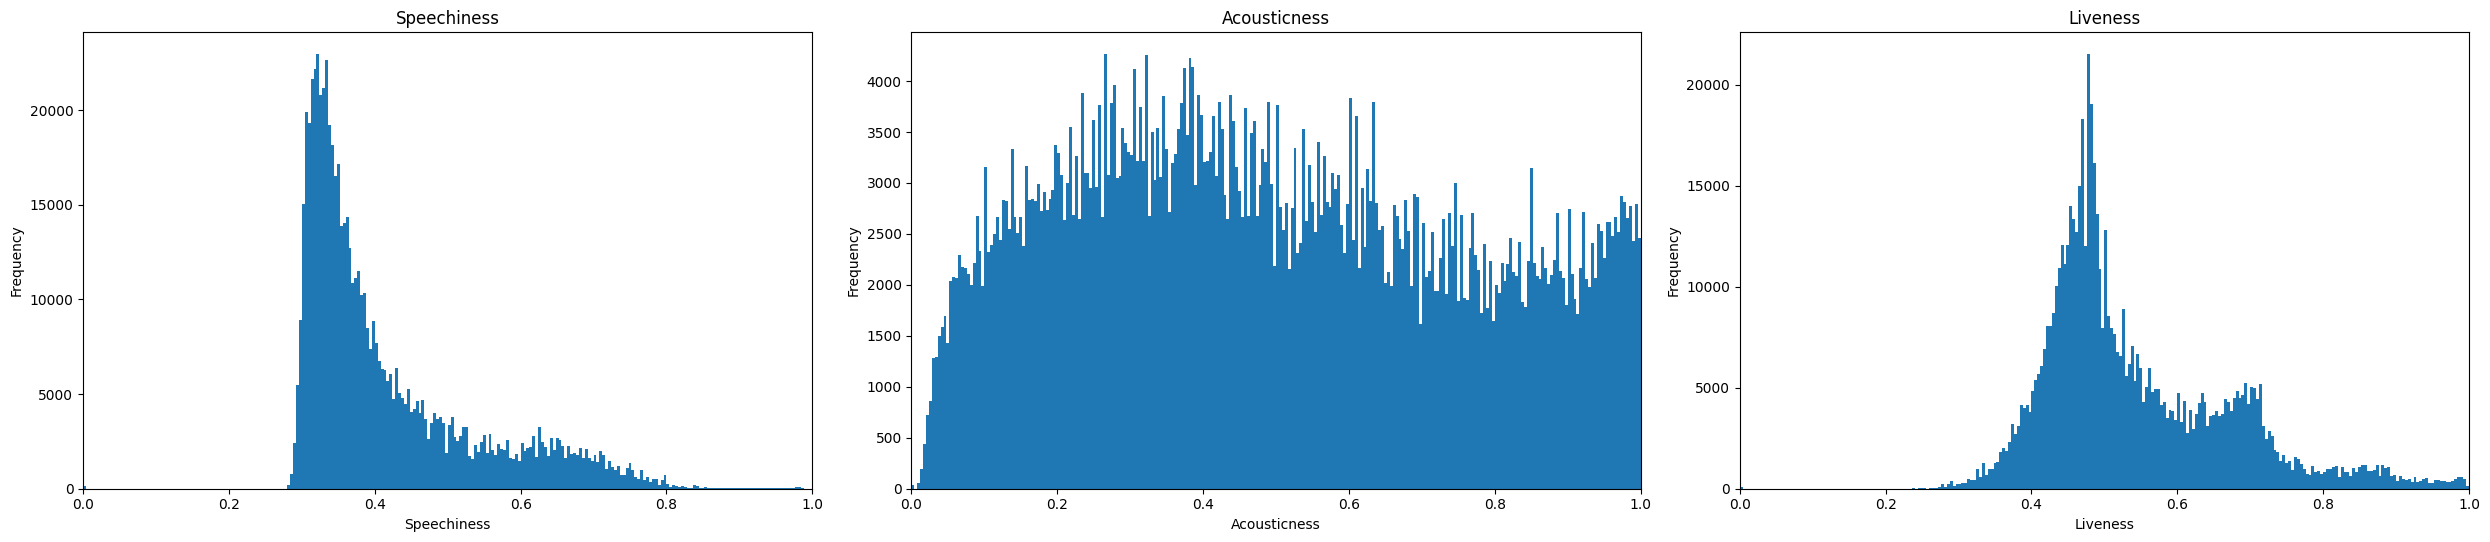

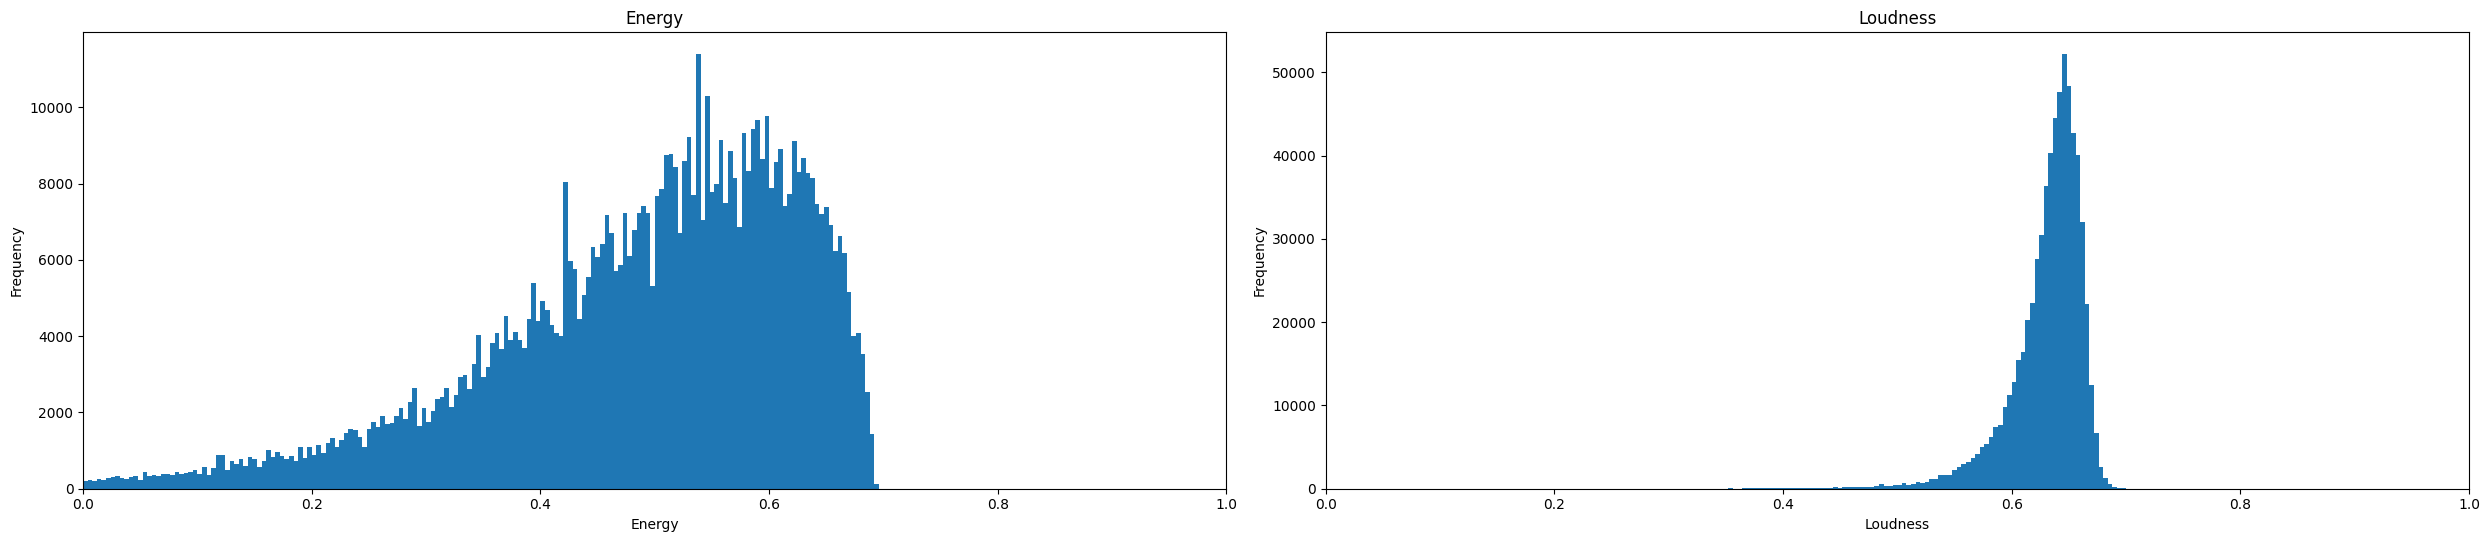

In [11]:
# Define the skewed columns
right_skewed_columns = ['speechiness', 'acousticness', 'liveness']
left_skewed_columns = ['energy', 'loudness']

# Apply transformations for both left and right skewed columns
for column in right_skewed_columns + left_skewed_columns:
    
    # Perform cube-root/logarithmic transformation to normalize dataset
    if column in right_skewed_columns:
        # Apply cube root transformation
        after_graph_audio_features_df.loc[:, column] = np.cbrt(before_graph_audio_features_df[column])
    elif column in left_skewed_columns:
        # Apply logarithmic transformation
        after_graph_audio_features_df.loc[:, column] = np.log1p(before_graph_audio_features_df[column].abs())

plot_title_right = 'Updated Right-skewed Columns with Cube Root Transformation'
plot_title_left = 'Updated Left-skewed Columns with Logarithmic Transformation'
plot_graph(plot_title_right, subplots_per_row=3, graph_features_list=right_skewed_columns, graph_df=after_graph_audio_features_df)
plot_graph(plot_title_left, subplots_per_row=2, graph_features_list=left_skewed_columns, graph_df=after_graph_audio_features_df)

before_graph_audio_features_df = after_graph_audio_features_df.copy()

### 4. Standard Normalization
Perform IQR-based outlier filtering and min-max normalization

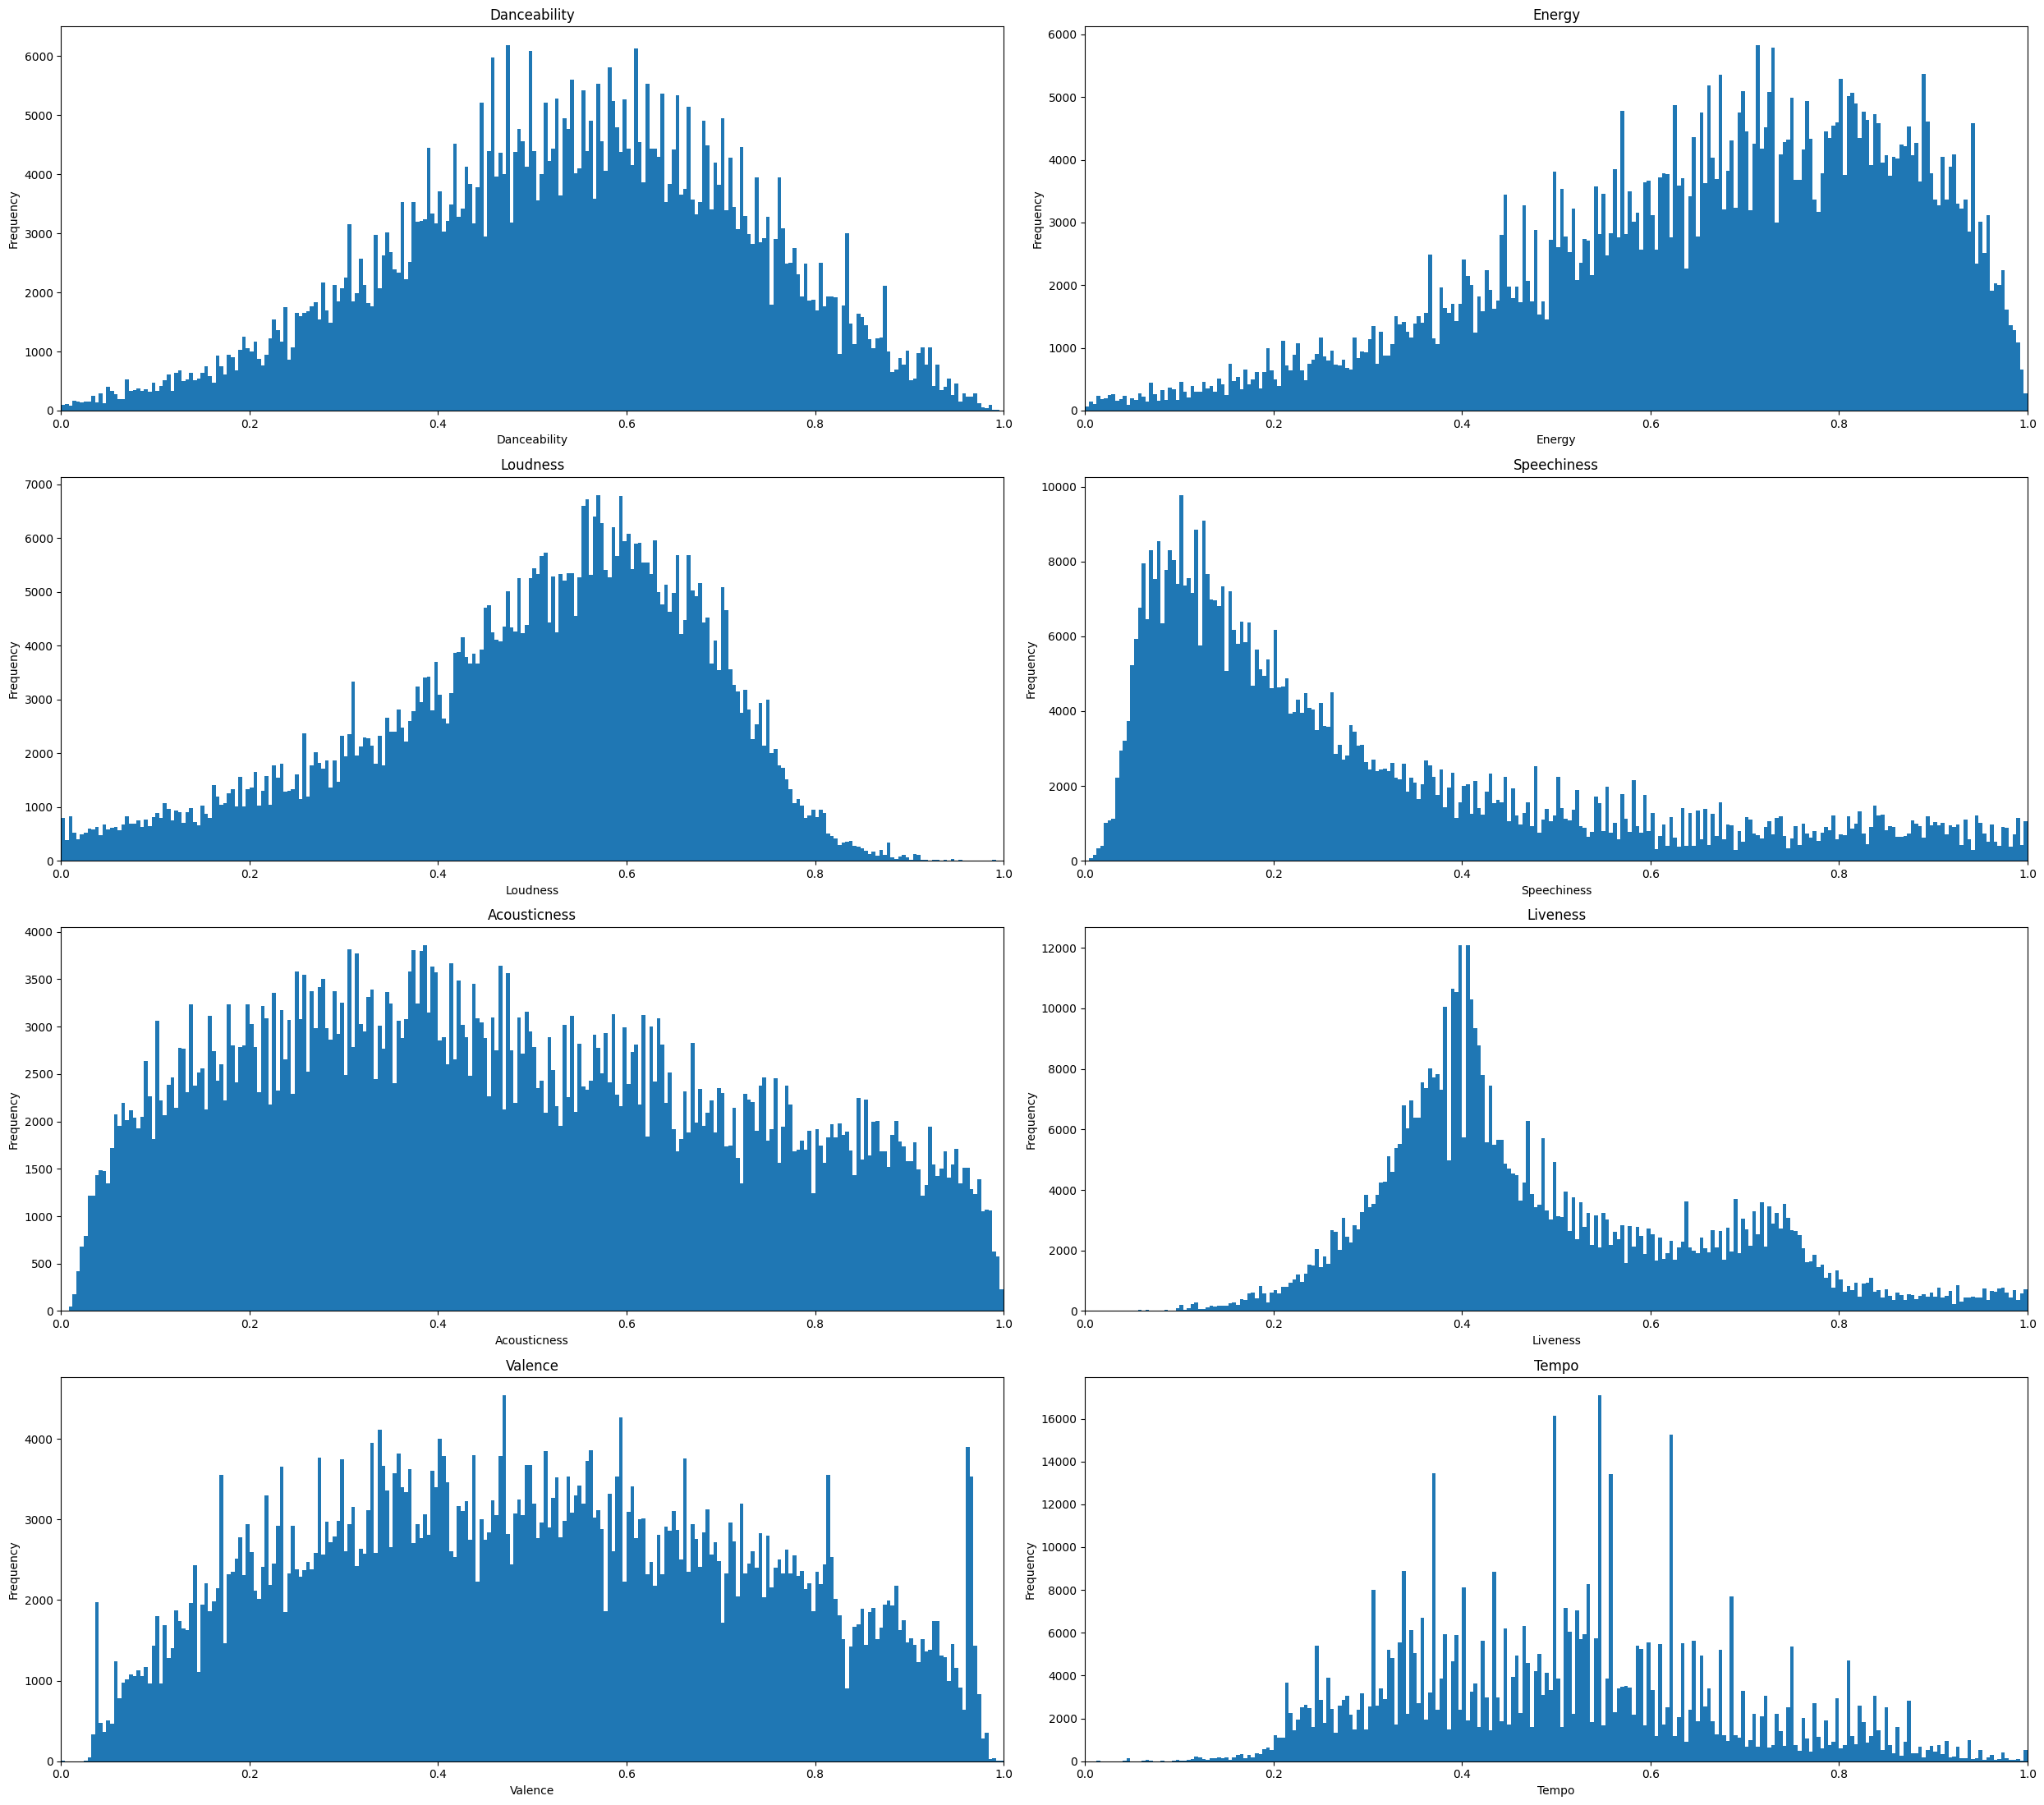

lower_thresholds = 
{'danceability': 0.16850000000000004, 'energy': 0.14936944969853527, 'loudness': 0.5734535346157168, 'speechiness': 0.11183139278235099, 'acousticness': -0.35285124201451823, 'liveness': 0.20276263879283324, 'valence': -0.24249999999999988, 'tempo': 0.16009000000000007}

upper_thresholds:
{'danceability': 1.0525, 'energy': 0.8605850164229211, 'loudness': 0.698995265917933, 'speechiness': 0.6924946680943335, 'acousticness': 1.280417950271011, 'liveness': 0.8754111662234604, 'valence': 1.2494999999999998, 'tempo': 0.7998179999999999}

feature_min:
{'danceability': 0.169, 'energy': 0.1501426584297195, 'loudness': 0.5734623376139655, 'speechiness': 0.27977873676275317, 'acousticness': 0.0, 'liveness': 0.21074564860592623, 'valence': 0.0, 'tempo': 0.164644}

feature_max:
{'danceability': 0.991, 'energy': 0.6931471805599453, 'loudness': 0.6983917371326527, 'speechiness': 0.692435557262704, 'acousticness': 0.9986648849277057, 'liveness': 0.8750340122833274, 'valence': 1.0,

In [12]:
lower_thresholds = {}
upper_thresholds = {}
feature_min = {}
feature_max = {}

for column in audio_features_list:
    
    Q1 = after_graph_audio_features_df[column].quantile(0.25)
    Q3 = after_graph_audio_features_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Perform IQR-based outlier filtering    
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    temp_after_graph_audio_features_df = after_graph_audio_features_df.copy()
    after_graph_audio_features_df = temp_after_graph_audio_features_df[
        (temp_after_graph_audio_features_df[column] > lower_threshold) &
        (temp_after_graph_audio_features_df[column] < upper_threshold)
    ]
    
    lower_thresholds[column] = Q1 - 1.5 * IQR
    upper_thresholds[column] = Q3 + 1.5 * IQR

    # Store min-max parameters for left-skewed columns
    column_min = after_graph_audio_features_df[column].min()
    column_max = after_graph_audio_features_df[column].max()
    
    feature_min[column] = column_min
    feature_max[column] = column_max
    
    after_graph_audio_features_df.loc[:, column] = (after_graph_audio_features_df[column] - column_min) / (column_max - column_min)

plot_title = 'Frequency Histogram for Processed Data'
plot_graph(plot_title, subplots_per_row=2, graph_features_list=audio_features_list, graph_df=after_graph_audio_features_df)

print("lower_thresholds = ")
print(lower_thresholds)

print("\nupper_thresholds = ")
print(upper_thresholds)

print('\nfeature_min = ')
print(feature_min)

print('\nfeature_max = ')
print(feature_max)

before_graph_audio_features_df = after_graph_audio_features_df.copy()

In [ ]:
audio_features_df = after_graph_audio_features_df.copy()

## Correlation Matrix
Overview of the correlation between audio features (note: correlation need not necessarily imply causation)

In [ ]:
correlation_matrix = audio_features_df[audio_features_list].corr()

# Create a mask to hide the lower triangle (including the diagonal)
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plotting the correlation matrix as a heatmap, showing only the values in the upper triangle
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0, mask=~mask)
plt.title("Correlation Matrix of Audio Features")
plt.savefig(f"../../resources/audio_feature_plots/correlation.png", format="png", dpi=50)
plt.show()

In [ ]:
merged_df = audio_features_df.merge(track_details_df, on='id', how='inner')

tracks_with_missing_details = merged_df.loc[merged_df['track_uri'].isna(), 'id']

merged_df = merged_df.drop(index=merged_df[merged_df['id'].isin(tracks_with_missing_details)].index)
original_merged_df = merged_df.copy()

## Audio Feature Trend Over the Years
Here's how the audio_features change over time

In [ ]:
trend_analysis_df = original_merged_df.copy()

trend_analysis_df = trend_analysis_df.dropna(subset=['release_date'])
selected_columns = ['danceability', 'energy', 'loudness', 'tempo', 'speechiness', 'acousticness', 'liveness', 'valence', 'release_date']
trend_analysis_df = trend_analysis_df[selected_columns]

trend_analysis_df['release_date'] = pd.to_datetime(trend_analysis_df['release_date'], errors='coerce')

trend_analysis_df['release_year'] = trend_analysis_df['release_date'].dt.to_period('Q').astype(str)
trend_analysis_df['release_year'] = trend_analysis_df['release_year'].apply(lambda x: x.replace('Q1', 'H1').replace('Q2', 'H1').replace('Q3', 'H2').replace('Q4', 'H2'))

trend_analysis_df = trend_analysis_df.groupby('release_year').mean().reset_index()

subplots_per_row = 2
num_rows = len(audio_features_list) // subplots_per_row + (len(audio_features_list) % subplots_per_row > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=subplots_per_row, figsize=(25, 6 * num_rows))
axes = axes.flatten()

for i, audio_feature in enumerate(audio_features_list):

    ax = axes[i]
    ax.plot(trend_analysis_df.index, trend_analysis_df[audio_feature], label=audio_feature)
    
    ax.set_title(f'{audio_feature.capitalize()} Over The Years')
    ax.grid(True)

#     # x_ticks: how often a label is drawn, x_labels: what the label is
#     x_ticks = trend_analysis_df.index[::120]
#     x_labels = [date.split("-")[0] for date in trend_analysis_df['release_year_month'][::120]]
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(x_labels, rotation=45)

plt.tight_layout()
plt.show()